<a href="https://colab.research.google.com/github/ddcreating/RL_code/blob/main/lab2_mdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Markov Decision Problems

# Exercise 1: Grid World
Compute the value funnction for the example 4.1 in the book.







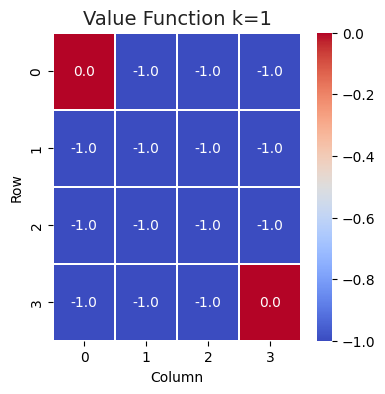

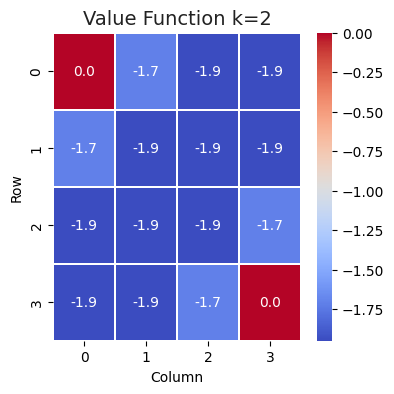

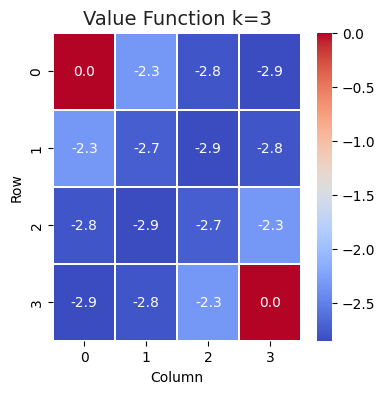

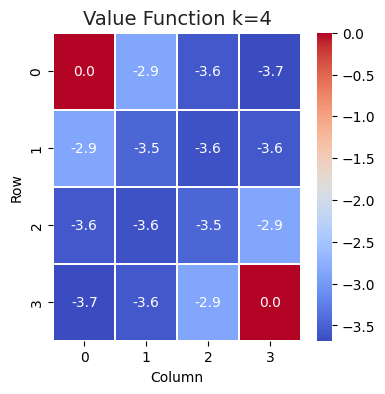

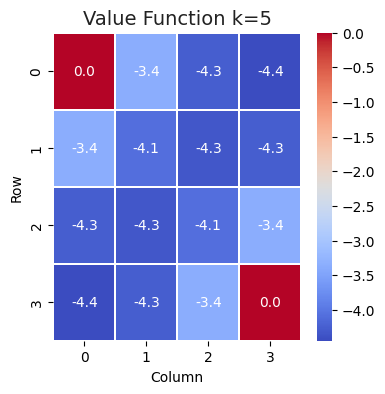

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def step(s, a):
    """Deterministic transition with boundary 'stay'."""
    if s in terminal_states:
        return s  # terminal stays as itself (won't be used in update anyway)

    r, c = divmod(s, n)
    if a == 'up':
        r2, c2 = (r-1, c) if r > 0 else (r, c)
    elif a == 'down':
        r2, c2 = (r+1, c) if r < n-1 else (r, c)
    elif a == 'left':
        r2, c2 = (r, c-1) if c > 0 else (r, c)
    elif a == 'right':
        r2, c2 = (r, c+1) if c < n-1 else (r, c)
    s_next = r2 * n + c2
    reward = -1.0               # -1 on all transitions
    return s_next, reward

# ----- Grid setup -----
n = 4                          # 4x4 grid
S = n * n                      # 16 states: 0..15
terminal_states = {0, 15}      # shaded cells in the book
gamma = 0.95                   # set to 1.0 if you want textbook-like numbers

# Equiprobable random policy over 4 actions
A = ['up', 'down', 'left', 'right']
pi = {a: 1.0/4 for a in A}

# ----- Iterative Policy Evaluation -----
V = np.zeros(S)
V_old = np.zeros(S)

K_iters = 5  # 与你截图一致；可改大些如 10/100 收敛更明显

for k in range(K_iters):
    V_old = V.copy()
    for s in range(S):
        if s in terminal_states:
            V[s] = 0.0
            continue
        # Bellman expectation backup under equiprobable random policy
        v = 0.0
        for a, prob in pi.items():
            s_next, r = step(s, a)
            v += prob * (r + gamma * V_old[s_next])
        V[s] = v

    # ---- PLOT ----
    V_grid = V.reshape((n, n))
    plt.figure(figsize=(4, 4))
    # vmin, vmax = np.percentile(V_grid, [5, 95])
    sns.heatmap(V_grid, annot=True, fmt=".1f", cmap="coolwarm", linewidths=1.2, linecolor="white",
                cbar=True, annot_kws={"color": "white", "fontsize": 10})
    plt.title(f"Value Function k={k+1}", fontsize=14, color="#222222")

    # sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5,
    #             cbar=False, square=True)
    # plt.title(f"Value Function k={k+1}")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


# Exercise 2: Grid World
Compute the optimal policy




V*:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]

Policy (slide-style ties):
■   ←   ←   ←↓ 
↑   ←↑  ←↓  ↓  
↑   ↑→  →↓  ↓  
↑→  →   →   ■  


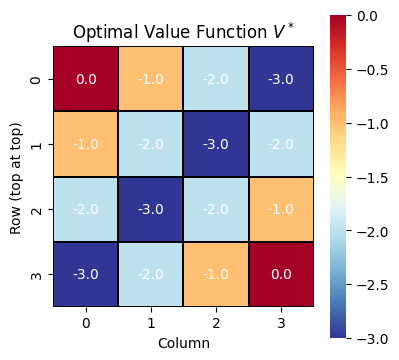

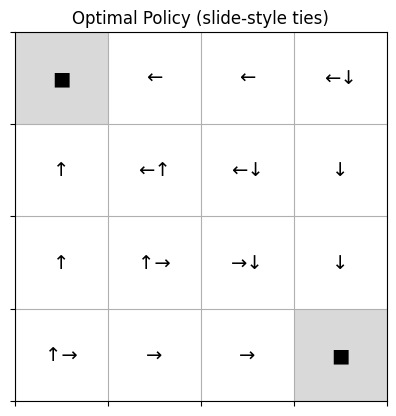

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Gridworld =====
n = 4
S = n * n
terminal_states = {0, 15}
A = ['up', 'down', 'left', 'right']
gamma = 1.0

def step(s, a):
    if s in terminal_states:
        return s, 0.0
    r, c = divmod(s, n)
    if a == 'up':
        r2, c2 = (r-1, c) if r > 0 else (r, c)
    elif a == 'down':
        r2, c2 = (r+1, c) if r < n-1 else (r, c)
    elif a == 'left':
        r2, c2 = (r, c-1) if c > 0 else (r, c)
    else:  # right
        r2, c2 = (r, c+1) if c < n-1 else (r, c)
    return r2 * n + c2, -1.0

# ===== Value Iteration -> V* =====
V = np.zeros(S, dtype=float)
theta = 1e-8
while True:
    delta, V_old = 0.0, V.copy()
    for s in range(S):
        if s in terminal_states:
            V[s] = 0.0
            continue
        q = []
        for a in A:
            s_next, r = step(s, a)
            q.append(r + gamma * V_old[s_next])
        V[s] = max(q)
        delta = max(delta, abs(V[s] - V_old[s]))
    if delta < theta:
        break

# ===== Policy extraction (course-slide style) =====
arrow = {'up': '↑', 'down': '↓', 'left': '←', 'right': '→'}
policy = np.full(S, '', dtype=object)
tol = 1e-12

for s in range(S):
    if s in terminal_states:
        policy[s] = '■'
        continue

    # 先取 Q 最大的所有方向
    q_map, q_vals = {}, []
    for a in A:
        s_next, r = step(s, a)
        val = r + gamma * V[s_next]
        q_map[a] = val
        q_vals.append(val)
    q_star = max(q_vals)
    best = [a for a, v in q_map.items() if abs(v - q_star) <= tol]

    # --- 课件 tie-break 规则 ---
    r, c = divmod(s, n)
    # 只在 (1,2) 和 (2,1) 会出现四向并列（对称点：r+c == n-1）
    if len(best) == 4 and r + c == n - 1:
        if r < c:           # 例如 (1,2)
            best = ['left', 'down']   # ← 和 ↓
        else:               # 例如 (2,1)
            best = ['up', 'right']    # ↑ 和 →
    # 其它情况：保留本就并列的 1~2 个方向即可

    # 输出顺序按 课件习惯：左 → 上 → 右 → 下
    order = ['left', 'up', 'right', 'down']
    policy[s] = ''.join(arrow[a] for a in order if a in best)

# ===== 打印与可视化 =====
V_grid = V.reshape(n, n)
pi_grid = policy.reshape(n, n)

print("V*:")
print(np.round(V_grid, 1))
print("\nPolicy (slide-style ties):")
for row in pi_grid:
    print(' '.join(f'{cell:3s}' for cell in row))

# Heatmap（与坐标一致：左上是(0,0)）
plt.figure(figsize=(4.2, 4.2))
sns.heatmap(
    V_grid, annot=True, fmt=".1f",
    cmap="RdYlBu_r", linewidths=1.1, linecolor="black",
    cbar=True, square=True, annot_kws={"color": "white", "fontsize": 10}
)
plt.title("Optimal Value Function $V^*$")
plt.xlabel("Column"); plt.ylabel("Row (top at top)")
plt.show()

# 箭头网格
fig, ax = plt.subplots(figsize=(4.8, 4.8))
ax.set_xlim(0, n); ax.set_ylim(0, n)
ax.set_xticks(np.arange(n+1)); ax.set_yticks(np.arange(n+1))
ax.grid(True, which='both')

# 终止格子
for term in terminal_states:
    r, c = divmod(term, n)
    ax.add_patch(plt.Rectangle((c, r), 1, 1, facecolor='0.85', edgecolor='none'))

# 在中心写箭头文本
for s in range(S):
    r, c = divmod(s, n)
    ax.text(c + 0.5, r + 0.5, policy[s], ha='center', va='center', fontsize=14)

ax.set_xticklabels([]); ax.set_yticklabels([])
plt.title("Optimal Policy (slide-style ties)")
plt.gca().invert_yaxis()  # 让(0,0)显示在左上（视觉与表一致）
plt.show()


# Exercise 3: Grid World
In the following gym environment, compute the value function using Monte Carlo.

Run the following code in your local machine. You can run in on colab, but you will not see the animation.

In [4]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid

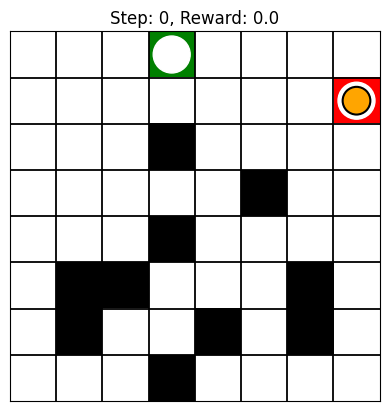

Location (2,7) t=0 reward=0.0
Location (2,6) t=1 reward=0.0
Location (1,6) t=2 reward=0.0
Location (2,6) t=3 reward=0.0
Location (3,6) t=4 reward=0.0
Location (4,6) t=5 reward=0.0
Location (4,6) t=6 reward=-1.0
Location (3,6) t=7 reward=0.0
Location (2,6) t=8 reward=0.0
Location (3,6) t=9 reward=0.0


In [5]:

import gymnasium as gym
import gym_simplegrid

START_LOC = 15
GOAL_LOC = 3
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='human')
obs, info = env.reset(seed=1, options=options)
done = env.unwrapped.done

for t in range(10):
    if done:
        break
    action = env.action_space.sample()   # Random action
    obs, reward, done, _, info = env.step(action)

    grid_size = 8
    row = obs // grid_size
    col = obs % grid_size
    print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()

Starting Monte Carlo value function estimation...


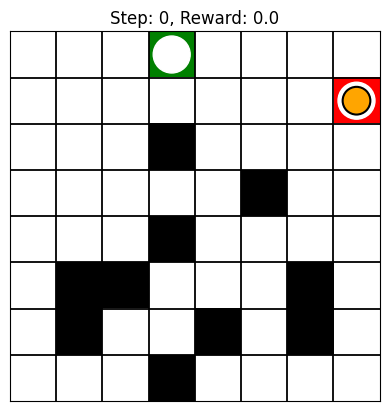

In [ ]:
import gymnasium as gym
import gym_simplegrid
import numpy as np
import matplotlib.pyplot as plt

START_LOC = 15
GOAL_LOC = 3

options = {
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

def run_episode(env, max_steps=100):
    obs, info = env.reset(seed=1, options=options)
    states = []
    rewards = []

    for step in range(max_steps):
        states.append(obs)
        action = env.action_space.sample()
        obs, reward, done, _, info = env.step(action)
        rewards.append(reward)

        if done:
            break

    return states, rewards

def monte_carlo_value_function(env, num_episodes=1000, gamma=0.99):
    returns = {}

    for episode in range(num_episodes):
        states, rewards = run_episode(env)

        G = 0
        for t in reversed(range(len(states))):
            G = rewards[t] + gamma * G
            state = states[t]

            if state not in states[:t]:
                if state not in returns:
                    returns[state] = []
                returns[state].append(G)

    value_function = {}
    for state in returns:
        value_function[state] = np.mean(returns[state])

    return value_function

def visualize_value_function(value_function, grid_size=8):
    grid = np.zeros((grid_size, grid_size))

    for state, value in value_function.items():
        row = state // grid_size
        col = state % grid_size
        grid[row, col] = value

    plt.figure(figsize=(8, 6))
    plt.imshow(grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Value')
    plt.title('Value Function (Monte Carlo)')

    for i in range(grid_size):
        for j in range(grid_size):
            state = i * grid_size + j
            if state in value_function:
                plt.text(j, i, f'{value_function[state]:.2f}',
                        ha='center', va='center', color='white', fontsize=8)

    start_row, start_col = START_LOC // grid_size, START_LOC % grid_size
    goal_row, goal_col = GOAL_LOC // grid_size, GOAL_LOC % grid_size

    plt.scatter(start_col, start_row, c='red', s=100, marker='s', label='Start')
    plt.scatter(goal_col, goal_row, c='green', s=100, marker='*', label='Goal')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    env = gym.make('SimpleGrid-8x8-v0', render_mode='human')

    print("Starting Monte Carlo value function estimation...")

    value_func = monte_carlo_value_function(env, num_episodes=5000)

    print(f"\nEstimated values for {len(value_func)} states:")
    for state in sorted(value_func.keys()):
        row, col = state // 8, state % 8
        print(f"State {state} (row{row},col{col}): {value_func[state]:.3f}")

    visualize_value_function(value_func)

    env.close()